<a href="https://colab.research.google.com/github/ethamCS/Juypter-public-/blob/main/module02_04_nn_and_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur and updated by Ross Beveridge

Last Update 10/05/2021

**The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


In [ ]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

# Subspaces, PCA and Nearest Neighbor

In this notebook we introduce a principled manner of selecting a smaller dimensional subspace fueled in part by the desire to carry out nearest neighbor calculations faster.  We will use the digits dataset to motivate and illustrate.

To begin here is the nearest neighbor implementation fromt the previous notebook

In [ ]:
def distance(x1, x2):
    return np.linalg.norm(x1-x2)

class nearest_neighbor:
    def __init__(self):
        pass
    def fit(self, X, y):
        self.X = X
        self.y = y
    def get_nearest(self, x):
        distances = [distance(x, self.X[i]) 
                     for i in range(len(self.X))]
        return np.argmin(distances)
    def predict(self, x) :
        return self.y[self.get_nearest(x)]

Bring in the digits dataset - recall each image is a point in 64 dimensional space.

In [ ]:
from sklearn import datasets
digits = datasets.load_digits()

X = digits.data
y = digits.target
print(X.shape, y.shape)

(1797, 64) (1797,)


## Principal Components Analysis 

Now let us see through example what PCA does can be used to accomplish. 

Note the example below can be adjusted to seek a different number of principal components with a useful minimum of 2 and a pratical useful upper bound of 10.  This is adjusted using ```subspace_size```

In [ ]:
from sklearn.decomposition import PCA

subspace_size = 2

pca = PCA(n_components=subspace_size)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In the next cell observe that a single command projects the original images (points in 64 dimensions) down to a subspace of size defined above. Note here that the entire dataset is being projected down into a lower dimensional subspace.  When doing PCA to reduce dimensionality in practice often the training data only is used to define the subspace.

In [ ]:
Xs = pca.transform(X)
Xs.shape

(1797, 2)

What follows will generate a scatter plot of the 10 digit classes as projected onto the first two principle components. If there are more than two dimensions the code does nothing but print a message

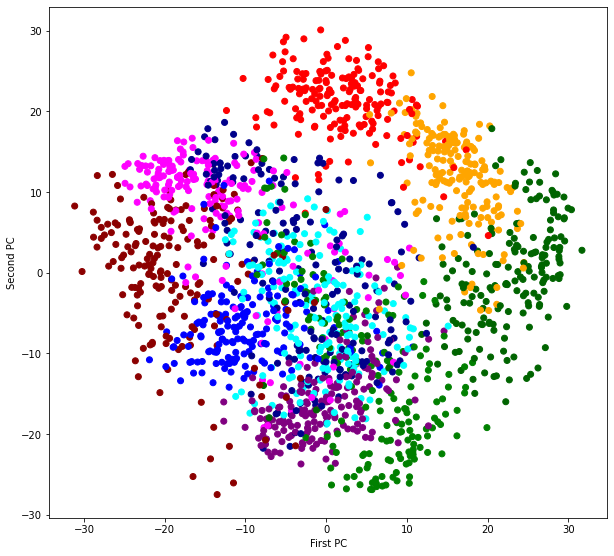

In [ ]:
def plot_if_only_two_dim(X, y) :
    if X.shape[1] == 2 :
        my_colors = ['red', 'green', 'blue', 'darkred', 'darkgreen', 'darkblue','orange','purple','cyan','magenta']

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.scatter(Xs[:,0], Xs[:,1], c=[my_colors[i] for i in y])
        ax.set_xlabel('First PC')
        ax.set_ylabel('Second PC')
    else :
        print("Not plotting since more than two dimensions")
        
plot_if_only_two_dim(Xs, y)       

The next code block is essentially identical to the previous notebook with the caveat that the nearest neighbor classifier is run on the data as it exists in the PCA subspace. Playing with different numbers of components quickly give us a feel for how many dimensions are required to essential match the performance in the original 64 dimensional ambient space.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, y, test_size=0.30, shuffle=True, random_state=42)

nnF = nearest_neighbor()
nnS = nearest_neighbor()

nnF.fit(X_train, y_train)
nnS.fit(Xs_train, ys_train)

def predict_with_nnF() :
    y_pred = np.array([nnF.predict(X_test[i]) for i in range(len(X_test))])
    acc = np.sum(y_pred == y_test)/len(y_test)
    print(f'The nnF accuracy is {acc:.3f}')
    
def predict_with_nnS() :
    y_pred = np.array([nnS.predict(Xs_test[i]) for i in range(len(Xs_test))])
    acc = np.sum(y_pred == ys_test)/len(ys_test)
    print(f'The nnS accuracy is {acc:.3f}')    
    
%timeit -r 1 -n 1 predict_with_nnF()
%timeit -r 1 -n 1 predict_with_nnS()

The nnF accuracy is 0.983
3.91 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
The nnS accuracy is 0.622
4.01 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The above timing information is thrown in for interest.  Truth be told the time savings working in the lower dimensional subspace are underwhelming for this example.  This is one of the "trust me" moments where you need to be aware that situations will arise where the extra effort to work in a low dimensional space will pay off.

## Looking at Principal Components

The remainder of this notebook emphasizes that fact that a component - being a vector if length 64 - may be thought of as an image. Indeed, it can be plotted.

In [ ]:
Xcps = pca.components_
Xcps.shape


(2, 64)

In [ ]:
foo = pca.explained_variance_ratio_
np.sum(foo)

0.28509364823695194

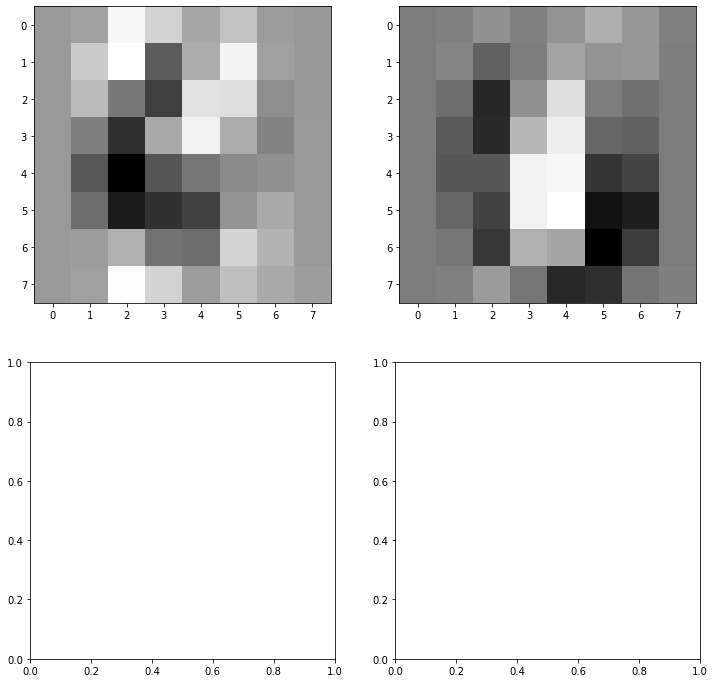

In [ ]:
Xcps = pca.components_
ncp  = Xcps.shape[0]
cols = 2
rows = (ncp // cols) + 1
cols
fig, axes = plt.subplots(rows, cols) 
fig.set_figheight(12)
fig.set_figwidth(12)
i = 0
for axr in axes :
    for ax in axr :
        if (i < ncp) :
            ax.imshow(np.resize(Xcps[i],(8,8)), 
                  cmap=plt.cm.gray_r, interpolation='nearest')
            i = i + 1
